## FFT 1D with the phase patterns

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-15
- last update : 2025-01-16 : shift position of origin at A point 
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import quad

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  24
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

## Introduction

### Diffraction of a parallel beam by a 1D aperture $x_1$ seen on a screen at $x_0$ 

We approximate the diffraction by an optical element with the 1D approximation, with the $x$ axis as the transverse coordinalte and the $z$ axis the wave propagation axis.
Taking the formula from the Goodman book we get the formula:

- in Fresnel approximation (spherical wave $\rightarrow$ quadratic terms in propagation term $\frac{e^{ikr_{01}}}{j\lambda z}$~:$z^3 \gg \frac{\pi}{4\lambda}\left(x_0-x_1\right)^4|_{max} $:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int \left\{ U(x_1) \exp\left(  j \frac{k}{2z}x_1^2\right)\right\} \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- in Fraunhofer approximation $ z \gg \frac{k(x_1^2+y_1)}{2}|_{max}$:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int  U(x_1)  \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- The Fraunhofer approximation solution is proportional to the Fourier transform of $U(x_1)$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- The Fresnel approximation solution is proportional to the Fourier transform of $\left \{ U(x_1) \cdot \exp\left(  j \frac{k}{2z}x_1^2\right) \right\}$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- $ \alpha$ is the incident angle on the focal line  in the $(X-Z)$ plane.

### Transform the parallel beam into a converging beam

- thin lens of focal length $\phi$ with a transmission function (depending on lens depth $\Delta_0$ and refractive index $n$):
$$
U_l(x) = \exp(j k\Delta_0 n) \cdot \exp(-j \frac{k}{2\phi}x^2)
$$
- When a lens (or mirror) transform a parallel beam into a converging beam at the location of an object and have a screen at the focal plane, the $\exp \left(j \frac{k}{2z}x_1^2 \right)$ is compensated by the lens term $\exp(-j \frac{k}{2\phi}x^2)$
- Thus a  converging lens (or mirror) transform a parallel beam Fresnel diffraction into a Fraunhofer diffraction, provided $z=\phi$.
$$
U(x_\phi) = \frac{exp(jk\phi)}{jk\phi} \exp\left(j \frac{k}{2\phi}x_{\phi}^2 \right) \int \int U(x)\cdot P(x) \times \exp 
\left\{ -j \frac{2 \pi}{\lambda \phi}x_\phi x\right\} dx 
$$

### The pupil function of the lens
$$
P(x) = \left\{ \begin{array}{c} 1 \;\; r < D/2 \\ 0 \;\;r > D/2 \end{array} \right.
$$

where $r=|x|$ and $D$ is the lens diameter.

## Function tools

In [3]:
def convert_angle_to_0_2pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    new_angle = np.where(new_angle < 0,np.abs(new_angle) + 2 * (np.pi - np.abs(new_angle)),new_angle)
    return new_angle

In [4]:
convert_angle_to_0_2pi_interval(-np.pi/4)

array(5.49778714)

In [5]:
def convert_angle_to_mpi_ppi_interval(angle):
    new_angle = convert_angle_to_0_2pi_interval(angle)
    new_angle = np.where(new_angle > np.pi, new_angle - 2*np.pi,new_angle)

    return new_angle

### Auxtel Configuration

In [6]:
# wavelength in m
wl = 0.5e-6
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [7]:
beam_radius_mm

5.0

### Diffraction Pattern

In [8]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin
a = 1/Neff

### Hologram recording

In [9]:
lambda_R = 0.639e-3 #mm
dR = 20.0  # mm
DR = dR/lambda_R/Neff

## Optical depth pattern function

The interference of the two point sources $A,B$ on the hologram emulsion is described
by the following formula
$$
U_{tot} = U_a + U_b = a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}}
$$
where $a,b$ are the complex amplitudes of the sources at their emission location and the exponential terms $\frac{e^{ikr}}{r}$ describe the outgoing spherical waves.

- If we approximate $\frac{1}{r_{AM}} \simeq \frac{1}{r_{BM}} \simeq \frac{1}{D_R}$,
- We redefine (a,b) by a relative phase shift between the souces $\Delta \psi$ and a relative positive amplitudes (by definition as the phase shift account for negative)
  $\cos \beta, \sin \beta$ such $0 \le \beta \le \frac{\pi}{4}$:
$$
\begin{array}{ccc}
a & = &a_0 \cos \beta e^{-i \frac{\Delta \psi}{2}} \\
b & = & a_0  \sin\beta  e^{i \frac{\Delta \psi}{2}}
\end{array}
$$

Redfining the coordinate in the recording plane $w$ by $x$:

$$
\begin{array}{ccc}
D_{AM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x \\
D_{BM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x 
\end{array}
$$

If we approximate $D_R \gg d_R,l,x$:

$$
\begin{array}{ccc}
D_{AM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x }{2D_R}\\
D_{BM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x }{2D_R}
\end{array}
$$


### Pattern recorded on emulsion

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

The periodicity is:

$$
\Delta x = \frac{\lambda_R D_R}{d_R}
$$

and the interference contrast $0 <C< 1$ is :

$ C = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \sin 2\beta$

- Note if the two sources have the same amplitudes within a phase shift the contrast is maximal.

In [10]:
def set_beam_aperture(x,radius = beam_radius_mm):
    """
    """
    a = np.where(np.logical_or(x<-radius,x>radius),0.,1.)
    return a

## Calculation of interference patterns

### 1) Definition of the full true interference pattern

In [11]:
def D_AM(x,y):
    """
    Distance in mm between A source and M point on emulsion
    """
    R2 = DR**2 +(dR/2.)**2+y**2 + dR*x
    return np.sqrt(R2)

In [12]:
def D_BM(x,y):
    """
    Distance in mm between B source and M point on emulsion
    """
    R2 = DR**2 +(dR/2.)**2+y**2 - dR*x
    return np.sqrt(R2)

$$
U_{tot} = U_a + U_b = D_R\left( a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}} \right)
$$

In [13]:
def InterferenceModule1(x,y,C=1,DPsi=0):
    """
    
    True inteferene pattern
    """
    
    # compute real positive amplitude from contrast
    
    cos_beta = np.sqrt((np.sqrt(1-C**2)+1)/2.)   
    sin_beta = np.sqrt((1-np.sqrt(1-C**2))/2.)    
    k_R = 2.*np.pi/lambda_R
    RAM = D_AM(x,y)
    RBM = D_BM(x,y)
    
    Ua = cos_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RAM)/RAM*DR
    Ub = sin_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RBM)/RBM*DR
    
    U = Ua+Ub
    Umod2 = np.abs(U)**2
    return Umod2/2

### 2) Definition of the partiel interference pattern

$$
U_{tot} = U_a + U_b = a\cdot e^{ikr_{AM}} + b\cdot e^{ikr_{BM}}
$$

In [14]:
def InterferenceModule2(x,y,C=1,DPsi=0):
    """  
    Simplified inteferene pattern with no dependence in denominator
    """
    
    # compute real positive amplitude from contrast
    
    cos_beta = np.sqrt((np.sqrt(1-C**2)+1)/2.)   
    sin_beta = np.sqrt((1-np.sqrt(1-C**2))/2.)    
    k_R = 2.*np.pi/lambda_R
    RAM = D_AM(x,y)
    RBM = D_BM(x,y)
    
    Ua = cos_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RAM)
    Ub = sin_beta*np.exp(1j*DPsi/2)*np.exp(1j*k_R*RBM)
    
    U = Ua+Ub
    Umod2 = np.abs(U)**2
    return Umod2/2

### 3) Definition of the simplified interference pattern

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

In [15]:
def InterferenceModule1D_3(x,C=0.5,DPsi=0):
    """
    Ultra simplifid 
    """
    cos_beta = np.sqrt((np.sqrt(1-C**2)+1)/2.)   
    sin_beta = np.sqrt((1-np.sqrt(1-C**2))/2.)    
    k_R = 2.*np.pi/lambda_R
    
    I = (1+C*np.cos(k_R*dR*x/DR -DPsi))/2.
    return I

In [16]:
def InterferenceModule1D_1(x,C=0.5,DPsi=0):
    return InterferenceModule1(x,0.,C=C,DPsi=DPsi)
def InterferenceModule1D_2(x,C=0.5,DPsi=0):
    return InterferenceModule2(x,0.,C=C,DPsi=DPsi)    

In [17]:
def InterferenceModule1D_1_A(x,C=0.5,DPsi=0):
    return InterferenceModule1D_1((x+dR/2),C=C,DPsi=DPsi)
def InterferenceModule1D_2_A(x,C=0.5,DPsi=0):
    return InterferenceModule1D_2((x+dR/2),C=C,DPsi=DPsi)
def InterferenceModule1D_3_A(x,C=0.5,DPsi=0):
    return InterferenceModule1D_3((x+dR/2),C=C,DPsi=DPsi)

## Plot Interference pattern and differences

In [18]:
# Beam contrast (between 0 and 1)
C=0.5
# Phase shift in radians
DPSI = 0

### Interference on 100 microns

(-0.1, 1.1)

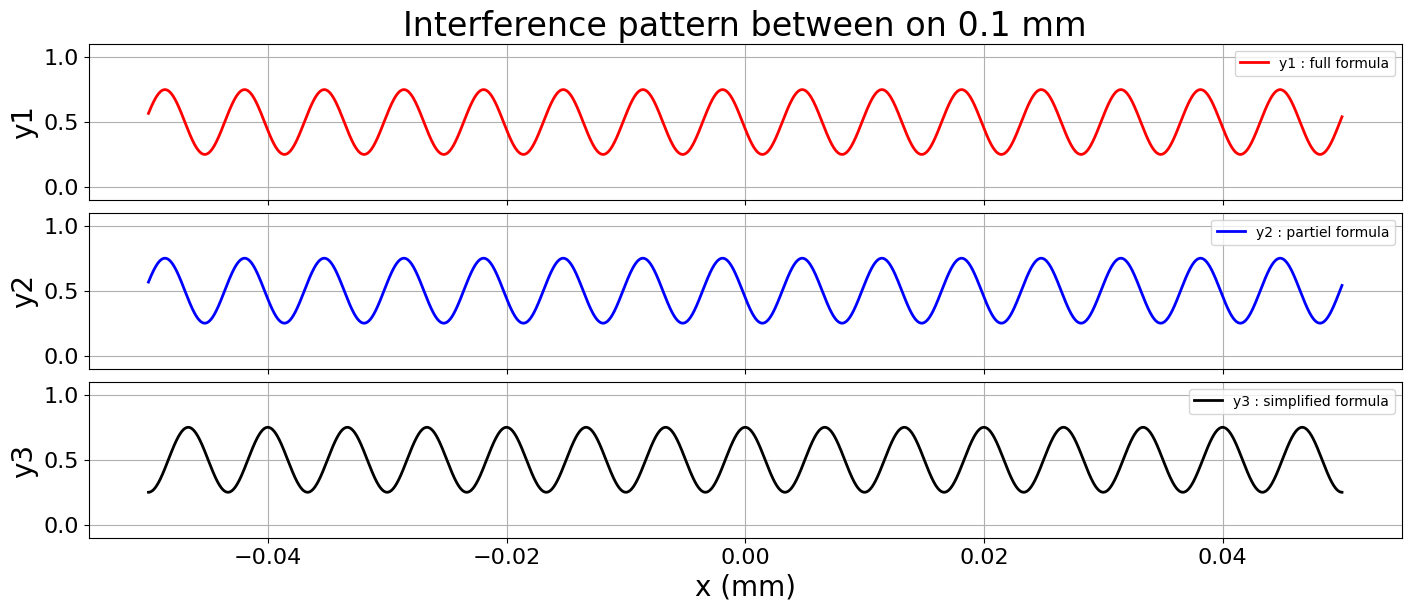

In [19]:
x = np.linspace(-.05,0.05,5000)
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True,sharey=True)
ax1.plot(x,y1,'r',label = "y1 : full formula")
ax2.plot(x,y2,'b',label = "y2 : partiel formula")
ax3.plot(x,y3,'k',label = "y3 : simplified formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()


ax1.set_title("Interference pattern between on 0.1 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1")
ax2.set_ylabel("y2")
ax3.set_ylabel("y3")
ax1.set_ylim(-0.1,1.1)

Text(0, 0.5, 'y1-y2')

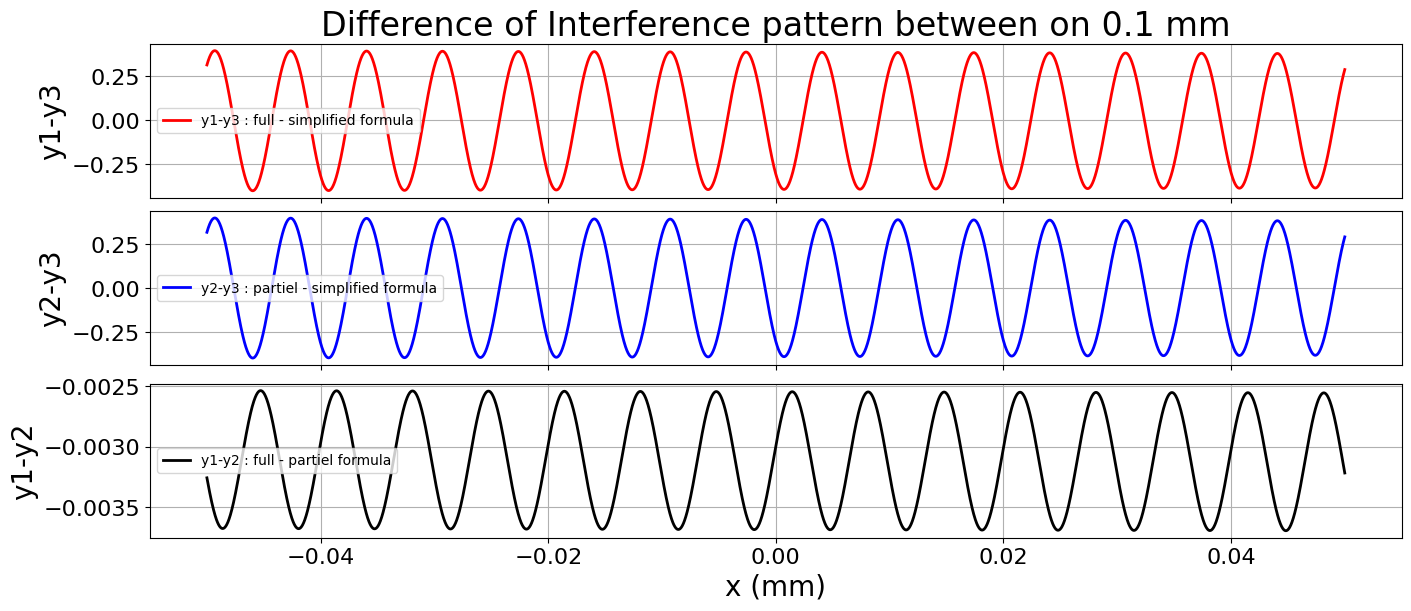

In [20]:
x = np.linspace(-.05,0.05,5000)
y1 = InterferenceModule1D_1_A(x,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True)
ax1.plot(x,y1-y3,'-r',label = "y1-y3 : full - simplified formula")
ax2.plot(x,y2-y3,'-b',label = "y2-y3 : partiel - simplified formula")
ax3.plot(x,y1-y2,'-k',label = "y1-y2 : full - partiel formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()

ax1.set_title("Difference of Interference pattern between on 0.1 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1-y3")
ax2.set_ylabel("y2-y3")
ax3.set_ylabel("y1-y2")

## FFT 1D

### Parameters of the FFT

In [21]:
#Nb = 10001
Nb = 20001
padding_factor = 1.5

#### The xe sampling

In [22]:
# x in units of mm
xe = np.linspace(-beam_radius_mm*padding_factor,+beam_radius_mm*padding_factor,Nb)
dxe = np.diff(xe).mean()
fe = 1/dxe
fmax = fe/2

In [23]:
print(f"Sampling distance dxe = {dxe} mm ")
print(f"Sampling frequency fe = {fe:.3f} mm -1")
print(f"Max signal requency fmax = {fmax:.3f} mm -1 before aliasing")
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Sampling distance dxe = 0.00075 mm 
Sampling frequency fe = 1333.333 mm -1
Max signal requency fmax = 666.667 mm -1 before aliasing
Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


#### The input aperture

In [24]:
ap = set_beam_aperture(xe)

Text(0.5, 0, 'mm')

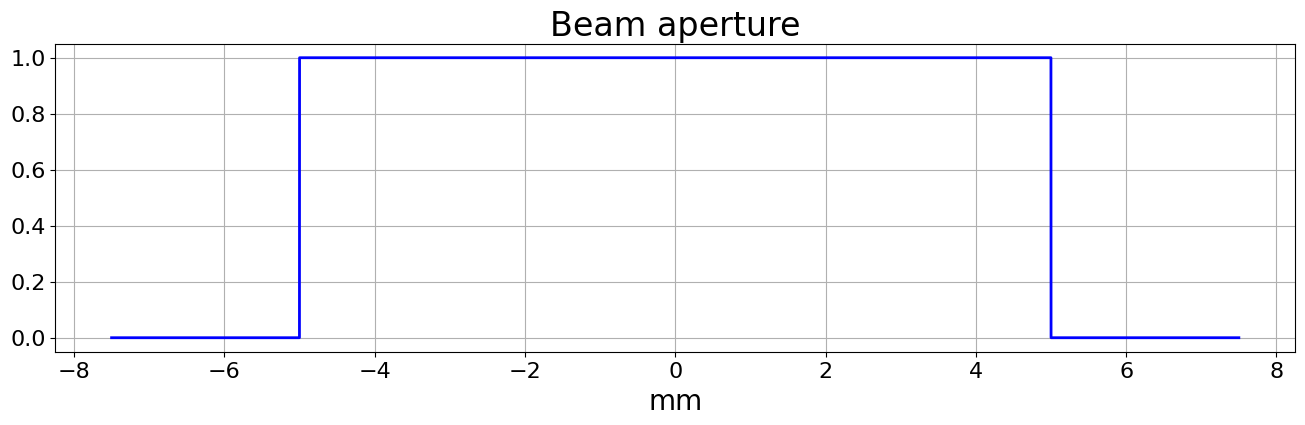

In [25]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = xe
y = ap
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Beam aperture")
ax.set_xlabel("mm")

#### The signals

In [26]:
def twosourcesinterf1D_1_A(x,C,DPSI):
    y = np.exp(1j*np.pi*InterferenceModule1D_1_A(x,C,DPSI)) 
    ycut = np.where(np.logical_or(x<-beam_radius_mm,x>beam_radius_mm),0.,y)
    return ycut

def twosourcesinterf1D_2_A(x,C,DPSI):
    y = np.exp(1j*np.pi*InterferenceModule1D_2_A(x,C,DPSI)) 
    ycut = np.where(np.logical_or(x<-beam_radius_mm,x>beam_radius_mm),0.,y)
    return ycut
 
def twosourcesinterf1D_3_A(x,C,DPSI):
    y = np.exp(1j*np.pi*InterferenceModule1D_3_A(x,C,DPSI)) 
    ycut = np.where(np.logical_or(x<-beam_radius_mm,x>beam_radius_mm),0.,y)
    return ycut

In [27]:
#y1 = ap*np.exp(1j*np.pi*InterferenceModule1D_1_A(xe,C,DPSI)) 
#y2 = ap*np.exp(1j*np.pi*InterferenceModule1D_2_A(xe,C,DPSI)) 
#y3 = ap*np.exp(1j*np.pi*InterferenceModule1D_3_A(xe,C,DPSI))

In [28]:
y1 = twosourcesinterf1D_1_A(xe,C,DPSI)
y2 = twosourcesinterf1D_2_A(xe,C,DPSI)
y3 = twosourcesinterf1D_3_A(xe,C,DPSI)

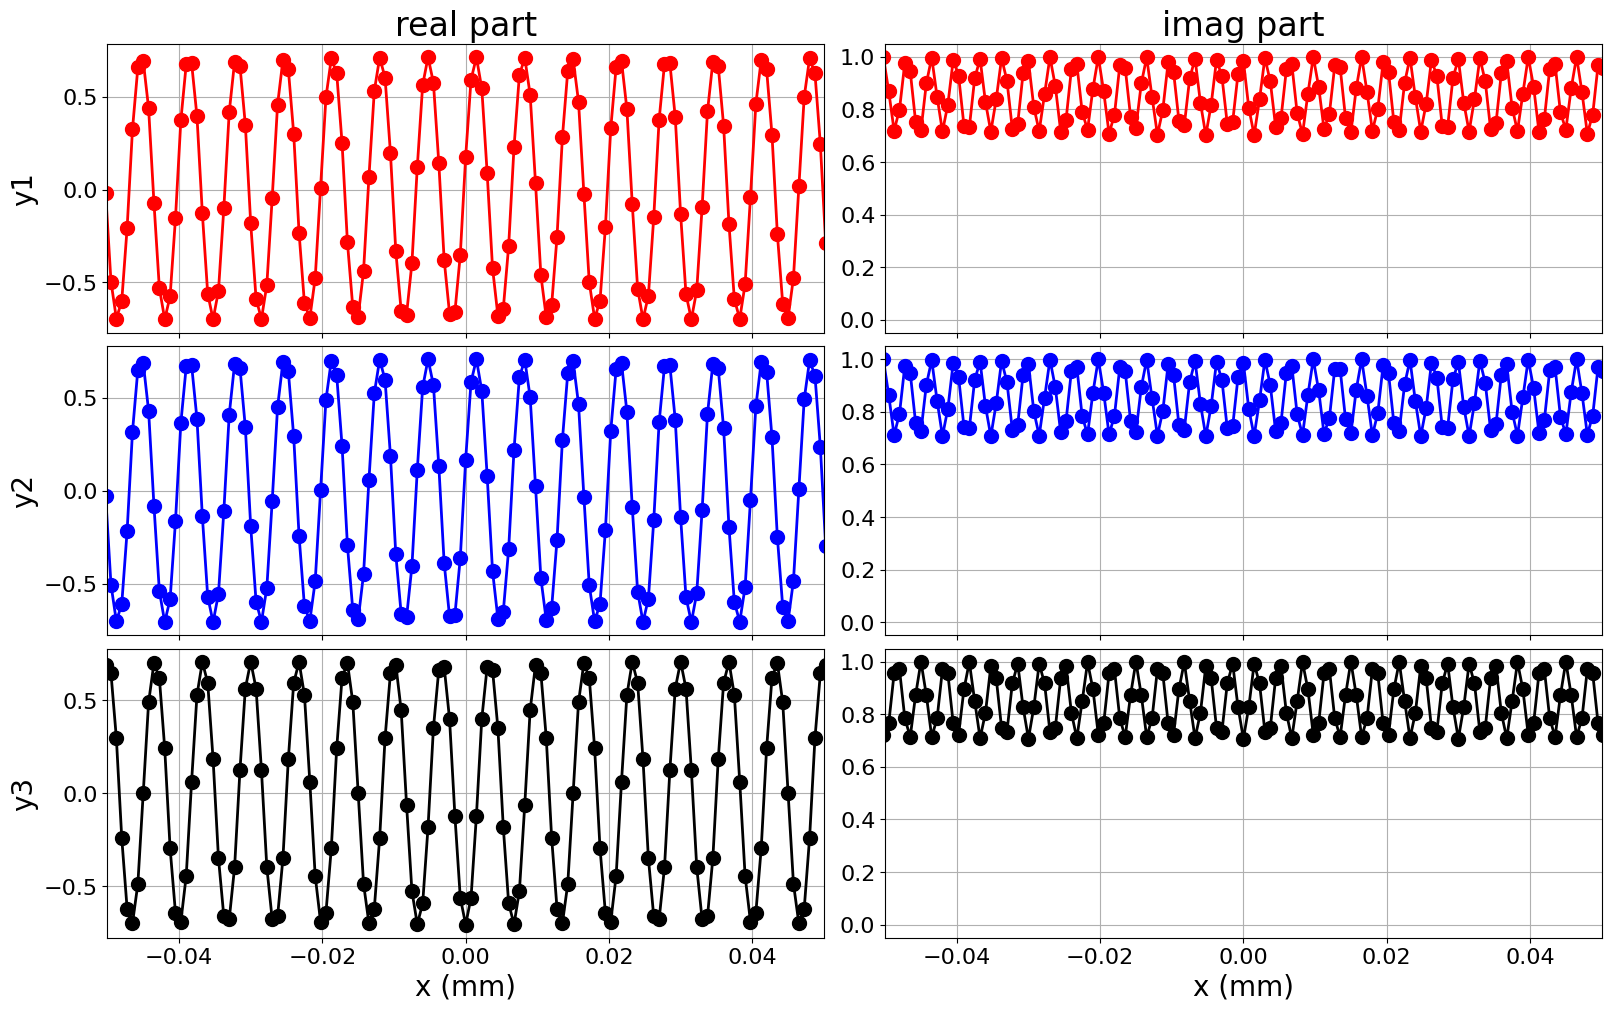

In [29]:
fig,axs = plt.subplots(3,2,figsize=(16,10),layout="constrained",sharex=True)
ax1,ax2,ax3,ax4,ax5,ax6 = axs.flatten()
ax1.plot(xe,y1.real,"o-r")
ax2.plot(xe,y1.imag,"o-r")
ax1.set_title("real part")
ax2.set_title("imag part")
ax1.set_ylabel("y1")


ax3.plot(xe,y2.real,"o-b")
ax4.plot(xe,y2.imag,"o-b")
ax3.set_ylabel("y2")

ax5.plot(xe,y3.real,"o-k")
ax6.plot(xe,y3.imag,"o-k")
ax5.set_ylabel("y3")
ax5.set_xlabel("x (mm)")
ax6.set_xlabel("x (mm)")

ax1.set_xlim(-0.05,0.05)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

### FFT for the beam with the optical element in place : Phase

In order that the two level of $ye$ to be in opposite phase, we must have
- $phase = \pi$ when ye =1
- $phase = 0$ when ye =0

In [30]:
def ComputeFFT(r):
    """
    """
    sp = np.fft.fft(r)
    # the frequency in units of mm^-1
    # do a deep copy
    freq = np.array(np.fft.fftfreq(r.shape[-1], d=dxe))
    real = np.array(sp.real)
    imag = np.array(sp.imag)
    module = np.array(np.abs(sp))
    phase = np.array(np.angle(sp))
    
    freq = np.fft.fftshift(freq)
    real = np.fft.fftshift(real)
    imag = np.fft.fftshift(imag)
    module = np.fft.fftshift(module)
    phase = np.fft.fftshift(phase)
    N = len(freq)
    return freq,real,imag,module,phase
    

In [31]:
freqa,reala,imaga,modulea,phasea = ComputeFFT(ap)
freq1,real1,imag1,module1,phase1 = ComputeFFT(y1)
freq2,real2,imag2,module2,phase2 = ComputeFFT(y2)
freq3,real3,imag3,module3,phase3 = ComputeFFT(y3)

### Order 1 and order 2 components

In [32]:
# compute the spatial frequency where the order 1 and 2 are
f_order1 = Neff
f_order2 = 2*Neff
f_order3 = 3*Neff

In [33]:
def plot_orders_regions(ax,df=1/beam_radius_mm):
    """
    
    """

    ax.axvline(x=df,c="pink",ls=":",label="order 0")
    ax.axvline(x=-df,c="pink",ls=":")

    if f_order1 < fmax:
        ax.axvline(x=f_order1+df,ls = ":",color="purple",label="order 1")
        ax.axvline(x=f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1+df,ls = ":",color="purple")
       
    if f_order2 < fmax:
        ax.axvline(x=f_order2+df,ls = ":",color="cyan",label="order 2")
        ax.axvline(x=f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2+df,ls = ":",color="cyan")

## Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

## Choose wat to plot

In [34]:
FLAG_FULL_INTERF = True
FLAG_PARTIAL_INTERF = False
FLAG_SIMPLE_INTERF = False

if FLAG_FULL_INTERF:
    freq,real,imag,module,phase  = freq1,real1,imag1,module1,phase1 
    tag = "full true interference pattern"
elif FLAG_PARTIAL_INTERF:
    freq,real,imag,module,phase  = freq2,real2,imag2,module2,phase2
    tag = "approximate interference pattern"
else:
    freq,real,imag,module,phase  = freq3,real3,imag3,module3,phase3
    tag = "oversimplified interference pattern"

In [35]:
def plotFFT(freq,real,imag,module,phase):
    """
    """
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=True)

    ax1.plot(freq, real, 'b',lw=3, label = "real")
    ax1.grid()
    plot_orders_regions(ax1)

    ax2.plot(freq, imag, 'r',lw=3, label = "imag")
    plot_orders_regions(ax2)
    ax2.grid()

    ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
    plot_orders_regions(ax3)
    ax3.grid()

    ax4.plot(freq, convert_angle_to_mpi_ppi_interval(phase),'.g',lw=3, label = "phase")
    plot_orders_regions(ax4)
    ax4.grid()
    ax4.set_xlabel("frequency in mm$^{-1}$")


    ax1.legend()
    ax1.set_ylabel("FFT real")
    ax2.legend()
    ax2.set_ylabel("FFT imag")
    ax3.legend()
    ax3.set_ylabel("FFT mod")
    ax4.legend()
    ax4.set_ylabel("FFT phase")
    return ax1

Text(0.5, 1.0, 'FFT of HOE for full true interference pattern ')

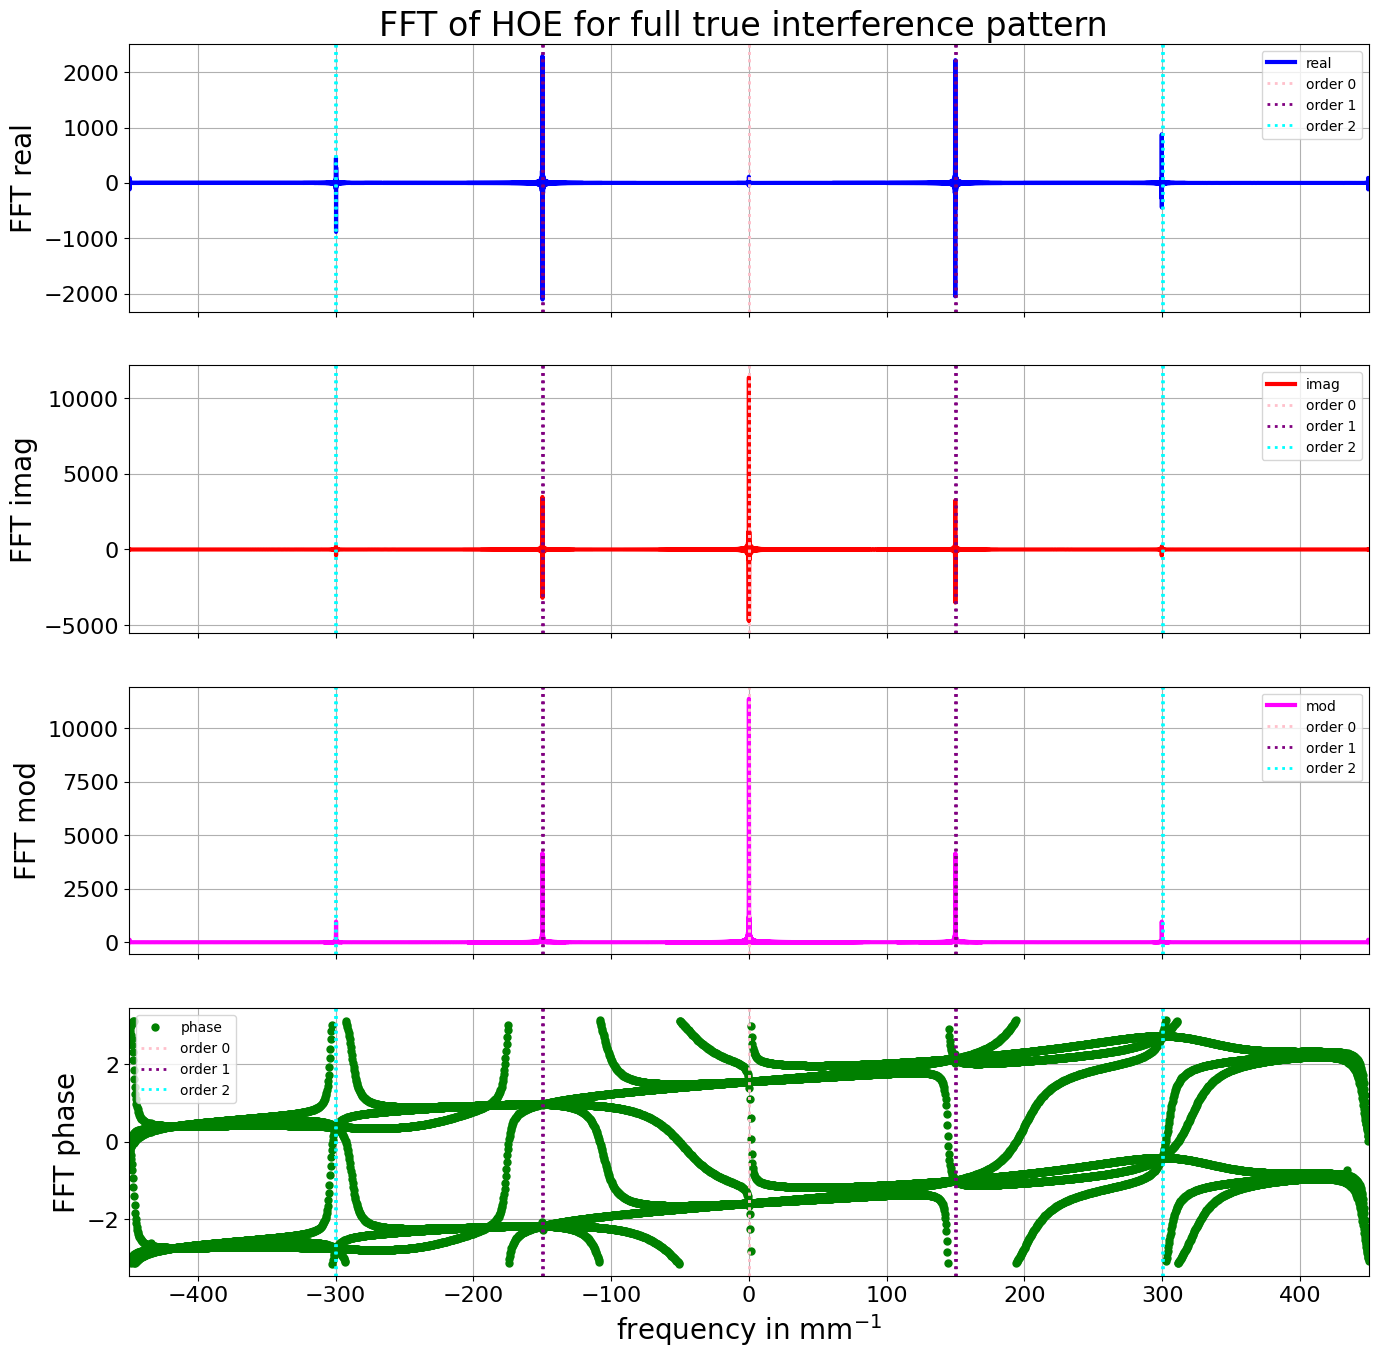

In [58]:
ax = plotFFT(freq,real,imag,module,phase)
ax.set_xlim(-f_order3,f_order3)
ax.set_title(f"FFT of HOE for {tag} ")

Text(0.5, 1.0, 'FFT of y3 : simplified interference pattern')

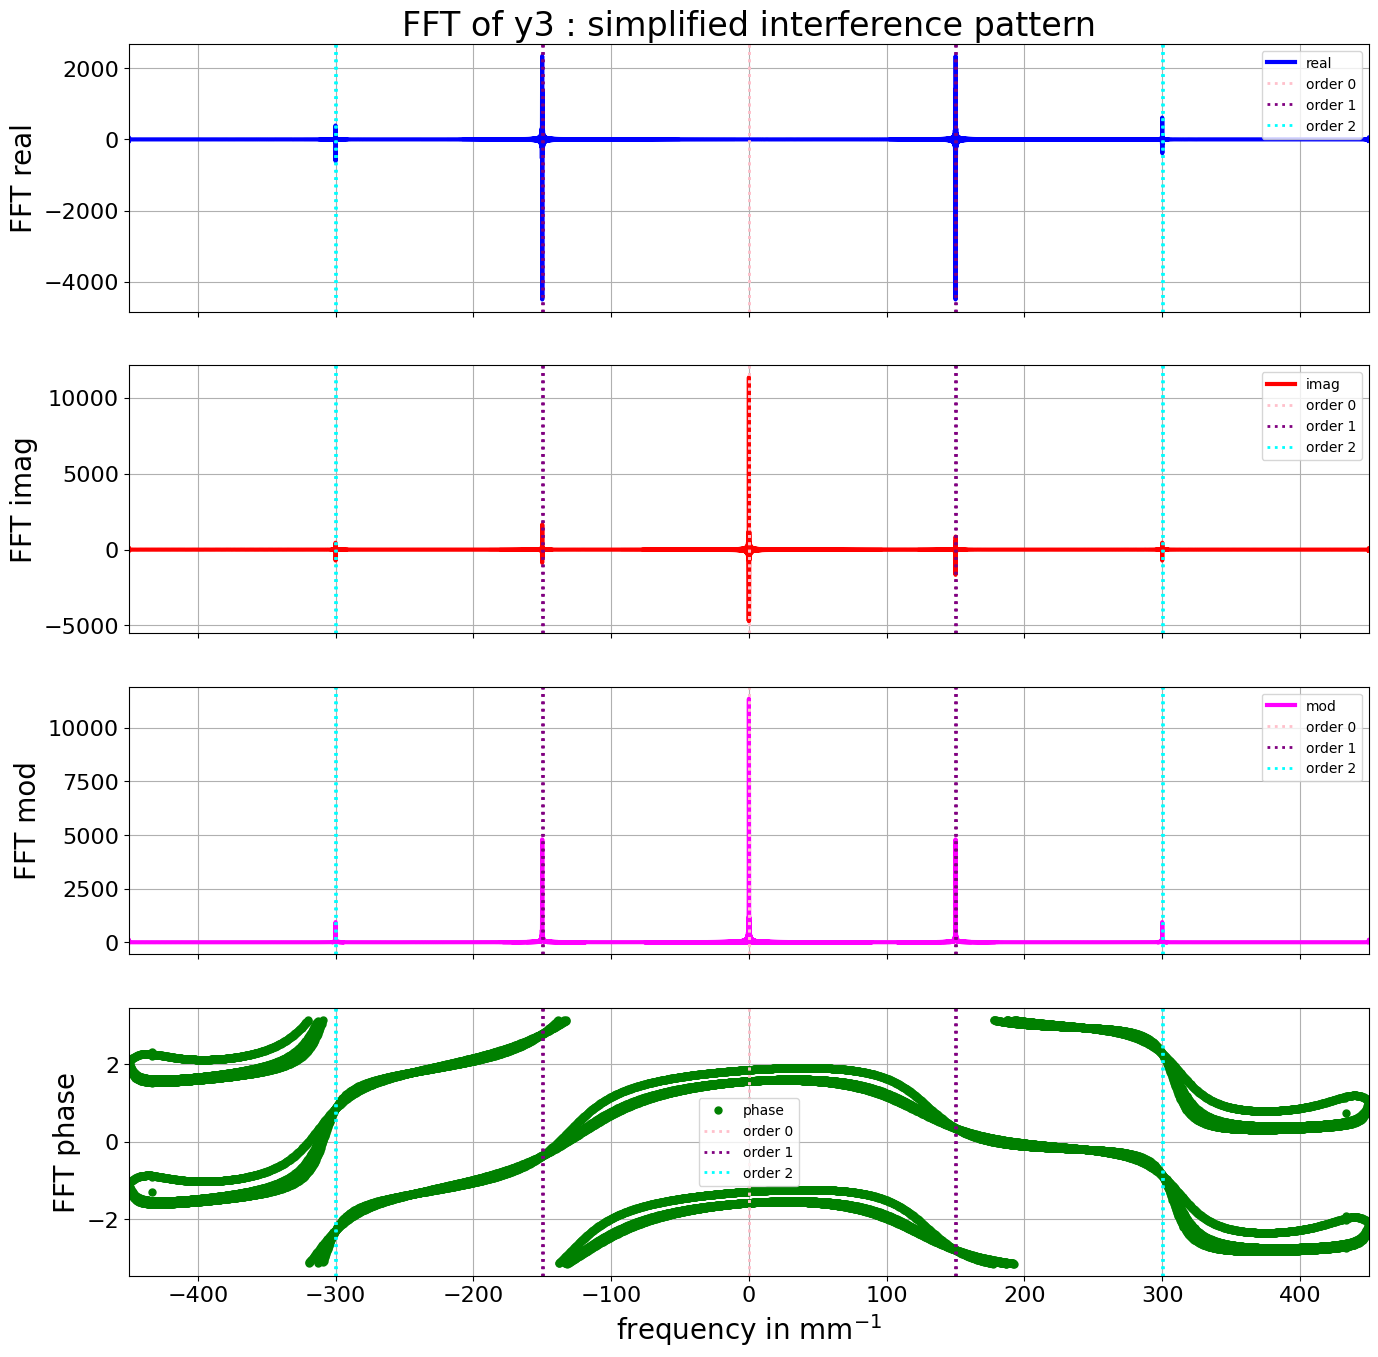

In [38]:
ax = plotFFT(freq3,real3,imag3,module3,phase3)
ax.set_xlim(-f_order3,f_order3)
ax.set_title("FFT of y3 : simplified interference pattern")

#### Plot the FFT coefficients in the aperture diffractive region

In [39]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


Text(0.5, 1.0, 'full true interference pattern: First Fourier components (order -1)')

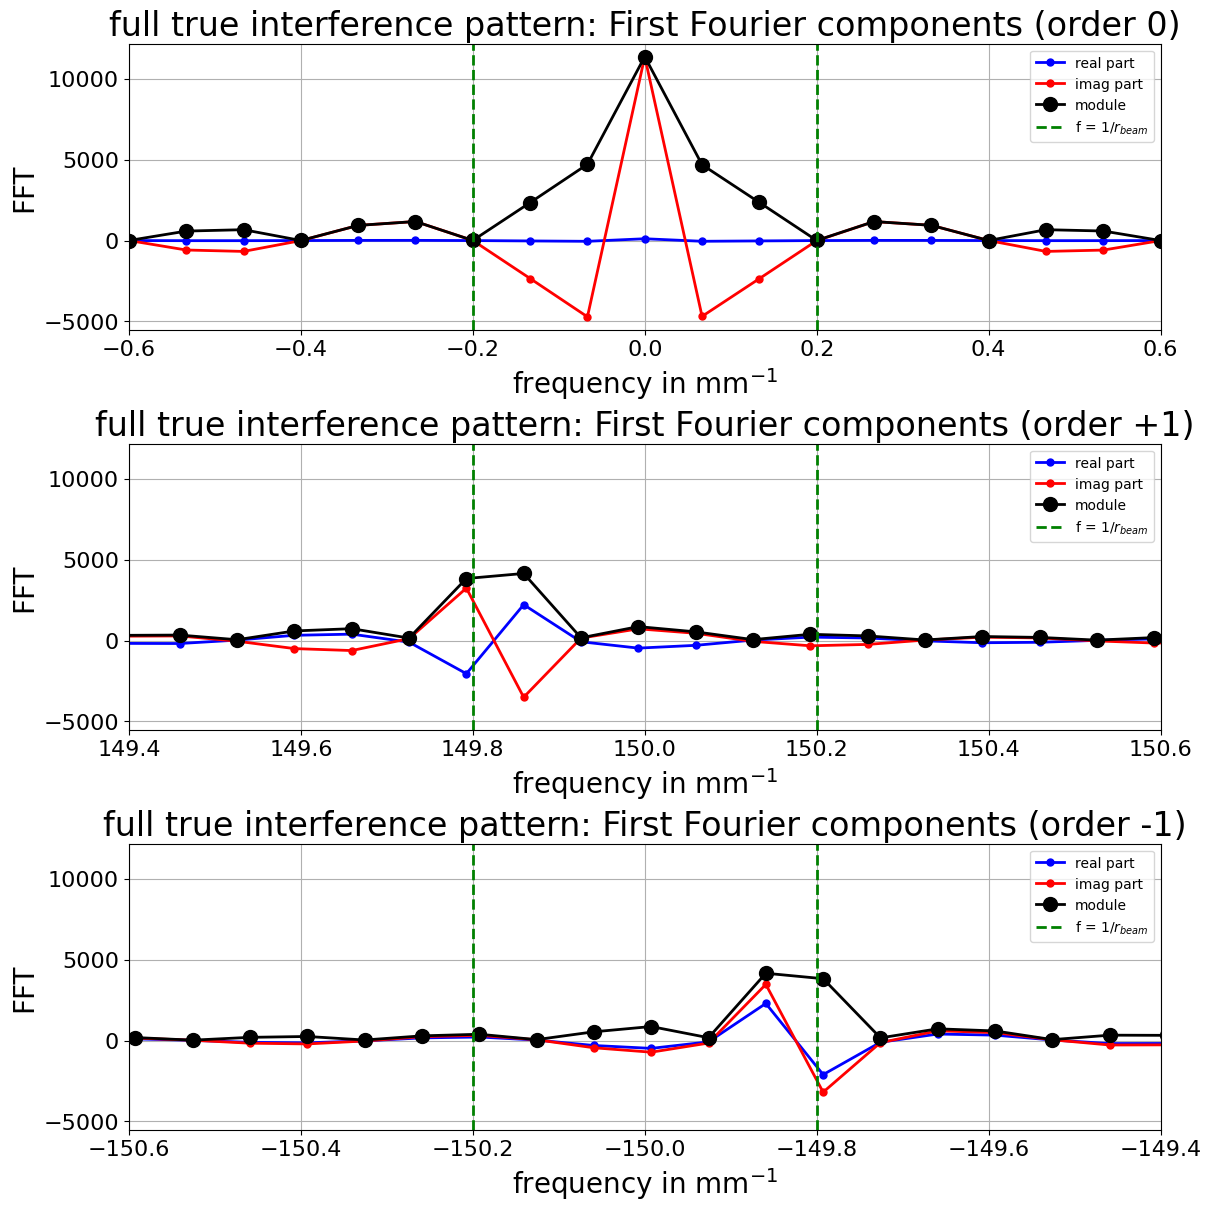

In [40]:
fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(12,12),layout="constrained")

DF = 3*1/beam_radius_mm

ax1.plot(freq,real,marker=".",c="b",label="real part")
ax1.plot(freq,imag,marker=".",c="r",label="imag part")
ax1.plot(freq,module,marker="o",c="k",label="module")
ax1.set_ylabel("FFT")
ax1.set_xlim(-DF,DF)

ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax1.grid()
ax1.legend()
ax1.set_title(f"{tag}: First Fourier components (order 0)")


ax2.plot(freq,real,marker=".",c="b",label="real part")
ax2.plot(freq,imag,marker=".",c="r",label="imag part")
ax2.plot(freq,module,marker="o",c="k",label="module")
ax2.set_ylabel("FFT")
ax2.set_xlim( f_order1 -DF , f_order1+ DF)

ax2.set_xlabel("frequency in mm$^{-1}$")
ax2.axvline(x=f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax2.axvline(x=f_order1 -1/beam_radius_mm,c="g",ls="--")
ax2.grid()
ax2.legend()
ax2.set_title(f"{tag}: First Fourier components (order +1)")


ax3.plot(freq,real,marker=".",c="b",label="real part")
ax3.plot(freq,imag,marker=".",c="r",label="imag part")
ax3.plot(freq,module,marker="o",c="k",label="module")
ax3.set_ylabel("FFT")
ax3.set_xlim( -f_order1 -DF , -f_order1+ DF)

ax3.set_xlabel("frequency in mm$^{-1}$")
ax3.axvline(x=-f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax3.axvline(x=-f_order1 -1/beam_radius_mm,c="g",ls="--")
ax3.grid()
ax3.legend()
ax3.set_title(f"{tag}: First Fourier components (order -1)")



In [41]:
DF = 5*1/beam_radius_mm
indexes_order_0 = np.where(np.abs(freq)<DF)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<DF)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<DF)[0]

Text(0.5, 0.98, 'full true interference pattern: Coefficients of FFT around order 0')

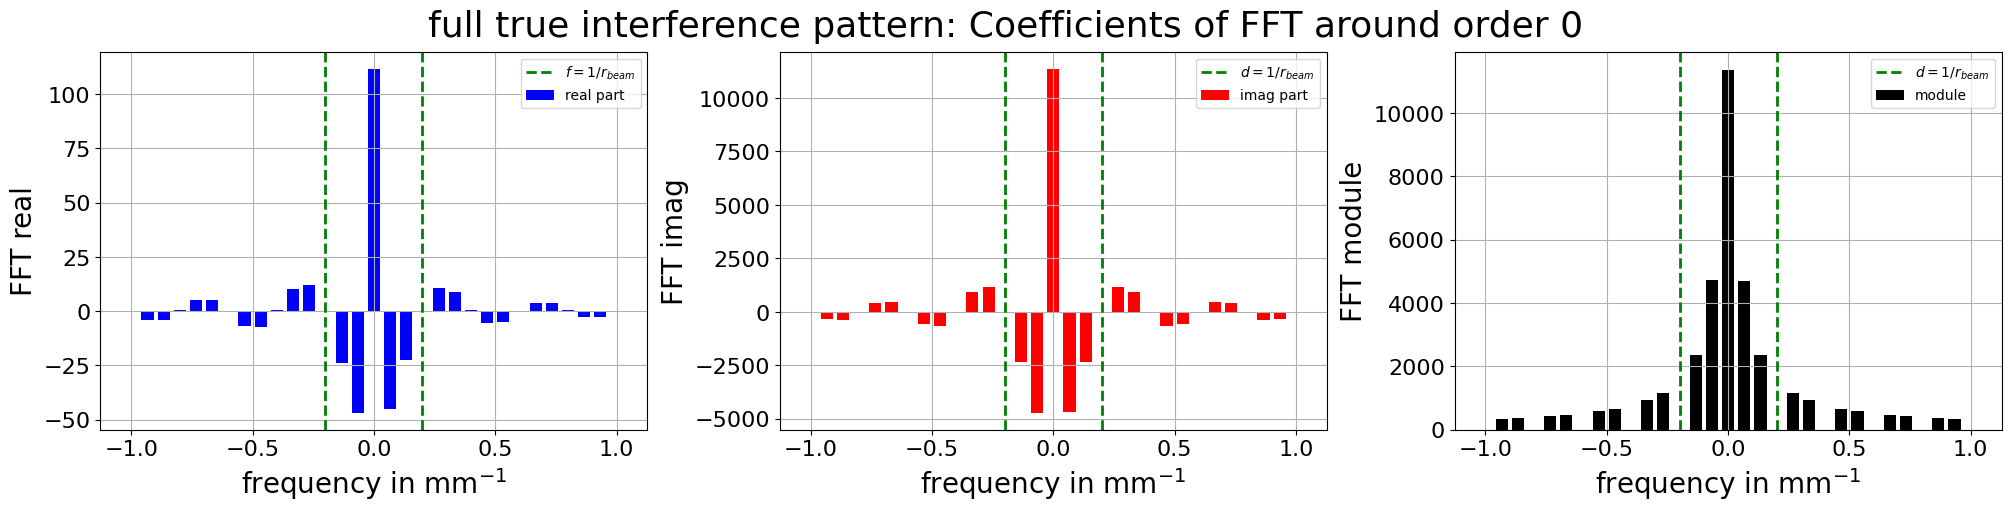

In [42]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_0],real[indexes_order_0],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_0],imag[indexes_order_0],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_0],module[indexes_order_0],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle(f"{tag}: Coefficients of FFT around order 0",fontsize=26)

Text(0.5, 0.98, 'full true interference pattern:Coefficients of FFT around order 1')

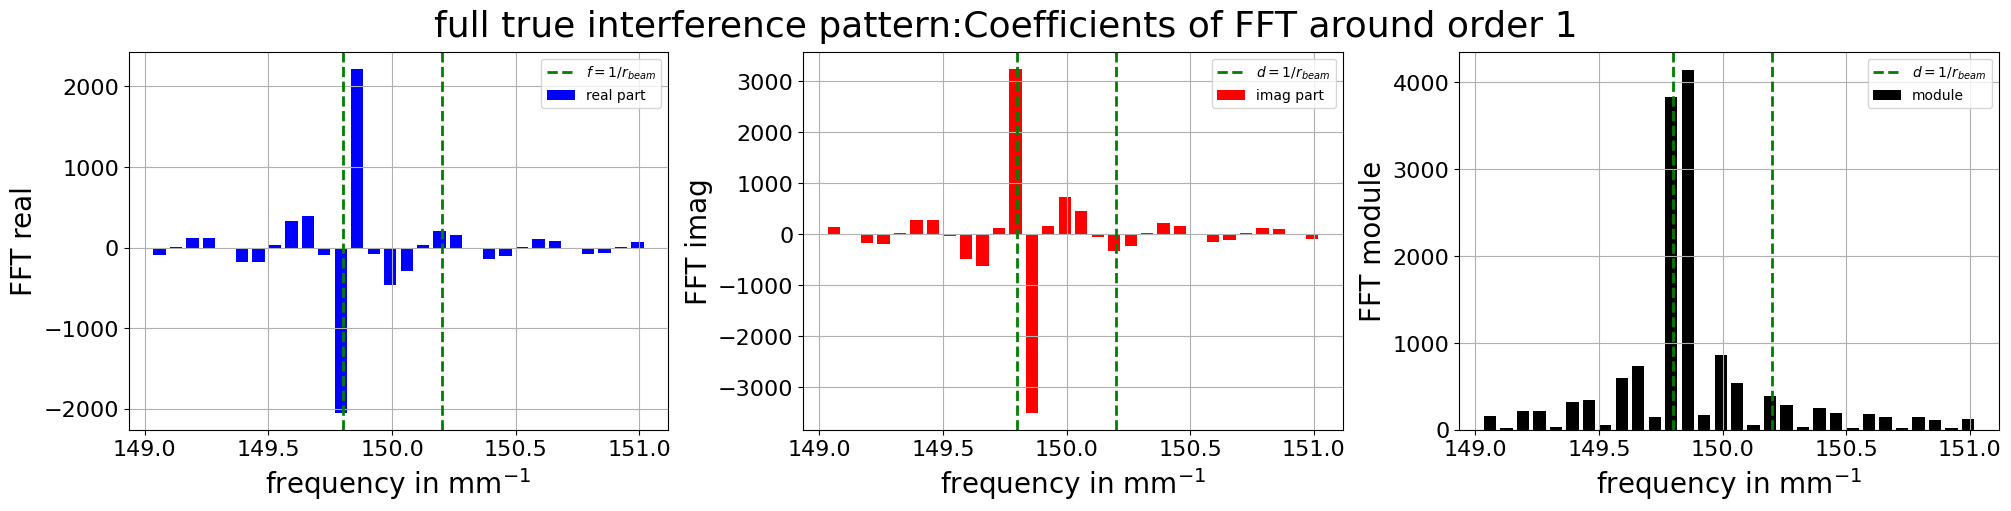

In [43]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_p1],real[indexes_order_p1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_p1],imag[indexes_order_p1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_p1],module[indexes_order_p1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle(f"{tag}:Coefficients of FFT around order 1",fontsize=26)

Text(0.5, 0.98, 'full true interference pattern:Coefficients of FFT around order -1')

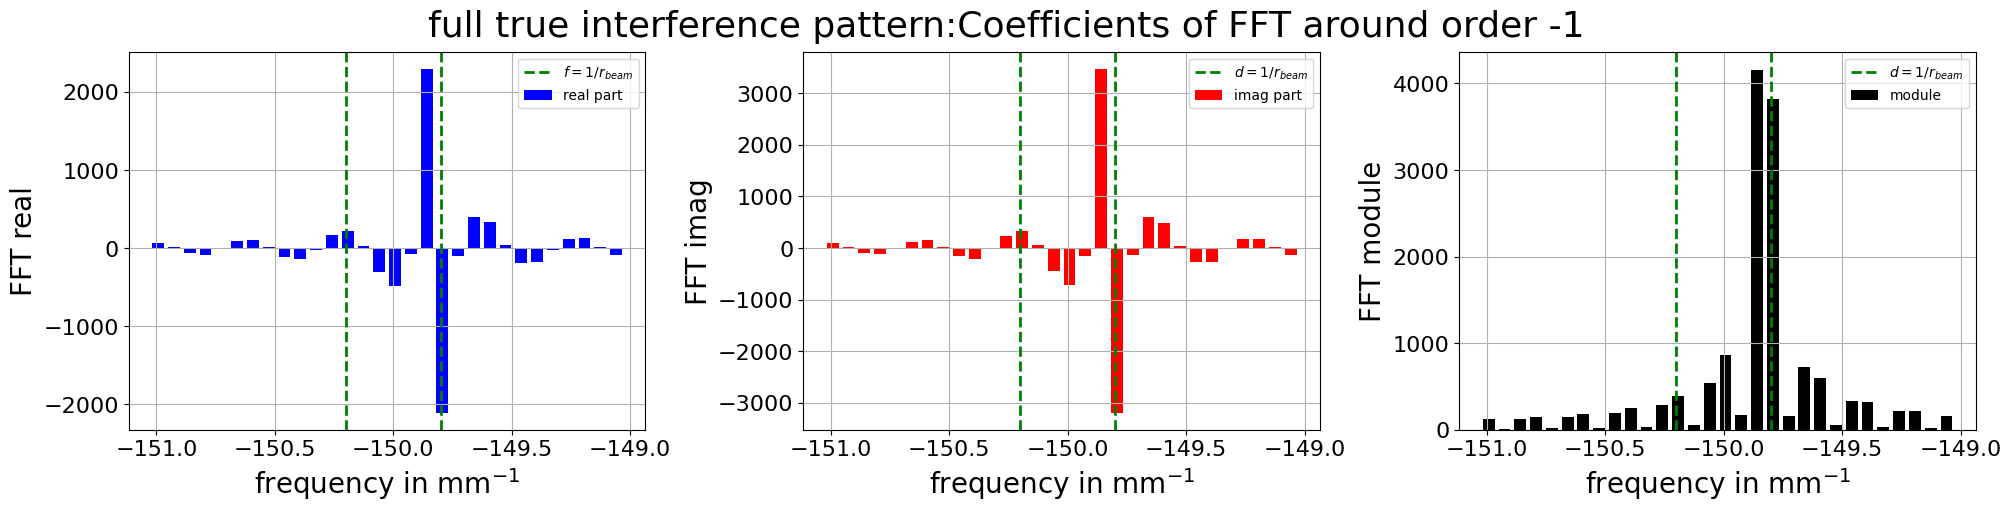

In [44]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_m1],real[indexes_order_m1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_m1],imag[indexes_order_m1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_m1],module[indexes_order_m1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle(f"{tag}:Coefficients of FFT around order -1",fontsize=26)

## Transmission efficiency

- calculation from the FFT

In [45]:
w_factor = 2.

In [46]:
indexesa_order_0 = np.where(np.abs(freqa)<w_factor/beam_radius_mm)[0]
indexes_order_0 = np.where(np.abs(freq)<w_factor/beam_radius_mm)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<w_factor/beam_radius_mm)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<w_factor/beam_radius_mm)[0]

In [47]:
coeffa_order_0 = modulea[indexesa_order_0]
coeff_order_0 = module[indexes_order_0]
coeff_order_p1 = module[indexes_order_p1]
coeff_order_m1 = module[indexes_order_m1]

In [48]:
efficiency_order0 = (coeff_order_0**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderp1 = (coeff_order_p1**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderm1 = (coeff_order_m1**2).sum()/(coeffa_order_0**2).sum()

In [49]:
print(f"FFT : Transmission efficiency of order 0 : {efficiency_order0:.4f}")
print(f"FFT : Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"FFT : Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

FFT : Transmission efficiency of order 0 : 0.7264
FFT : Transmission efficiency of order 1 : 0.1300
FFT : Transmission efficiency of order -1 : 0.1302


In [50]:
orderp1order0 = (coeff_order_p1**2).sum()/(coeff_order_0**2).sum()
orderm1order0 = (coeff_order_m1**2).sum()/(coeff_order_0**2).sum()

In [51]:
print(f"FFT : Transmission radio order +1/ order 0 : {orderp1order0:.4f}")
print(f"FFT : Transmission radio order -1/ order 0 : {orderm1order0:.4f}")

FFT : Transmission radio order +1/ order 0 : 0.1790
FFT : Transmission radio order -1/ order 0 : 0.1792


## Compute Fourier coefficients

- For real signal

- For $n=0$

$$
a_0 = \frac{1}{a} \int_{-a/2}^{a/2} t(x) dx
$$

- For $n>=1$ or $n <= -1$(better keep order 1 and -1 separately:
$$
a_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \cos(2\pi n \frac{x}{a}) dx
$$
$$
b_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \sin(2\pi n \frac{x}{a}) dx
$$
$$
c_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \exp(2\pi n \frac{x}{a}) dx
$$

In [52]:
xrange = np.linspace(-5*a,5*a,50000) 

In [53]:
def integrand_an_v0(x, n):
    return (set_beam_aperture(x,radius = beam_radius_mm)*np.cos(2*np.pi*n*x/a))/a
def integrand_bn_v0(x, n):
    return (set_beam_aperture(x,radius = beam_radius_mm)*np.sin(2*np.pi*n*x/a))/a
def integrand_cn_v0(x, n):
    return (set_beam_aperture(x,radius = beam_radius_mm)*np.exp(2j*np.pi*n*x/a))/a

Text(0.5, 1.02, 'Fourier coefficients calculation for beam aperture')

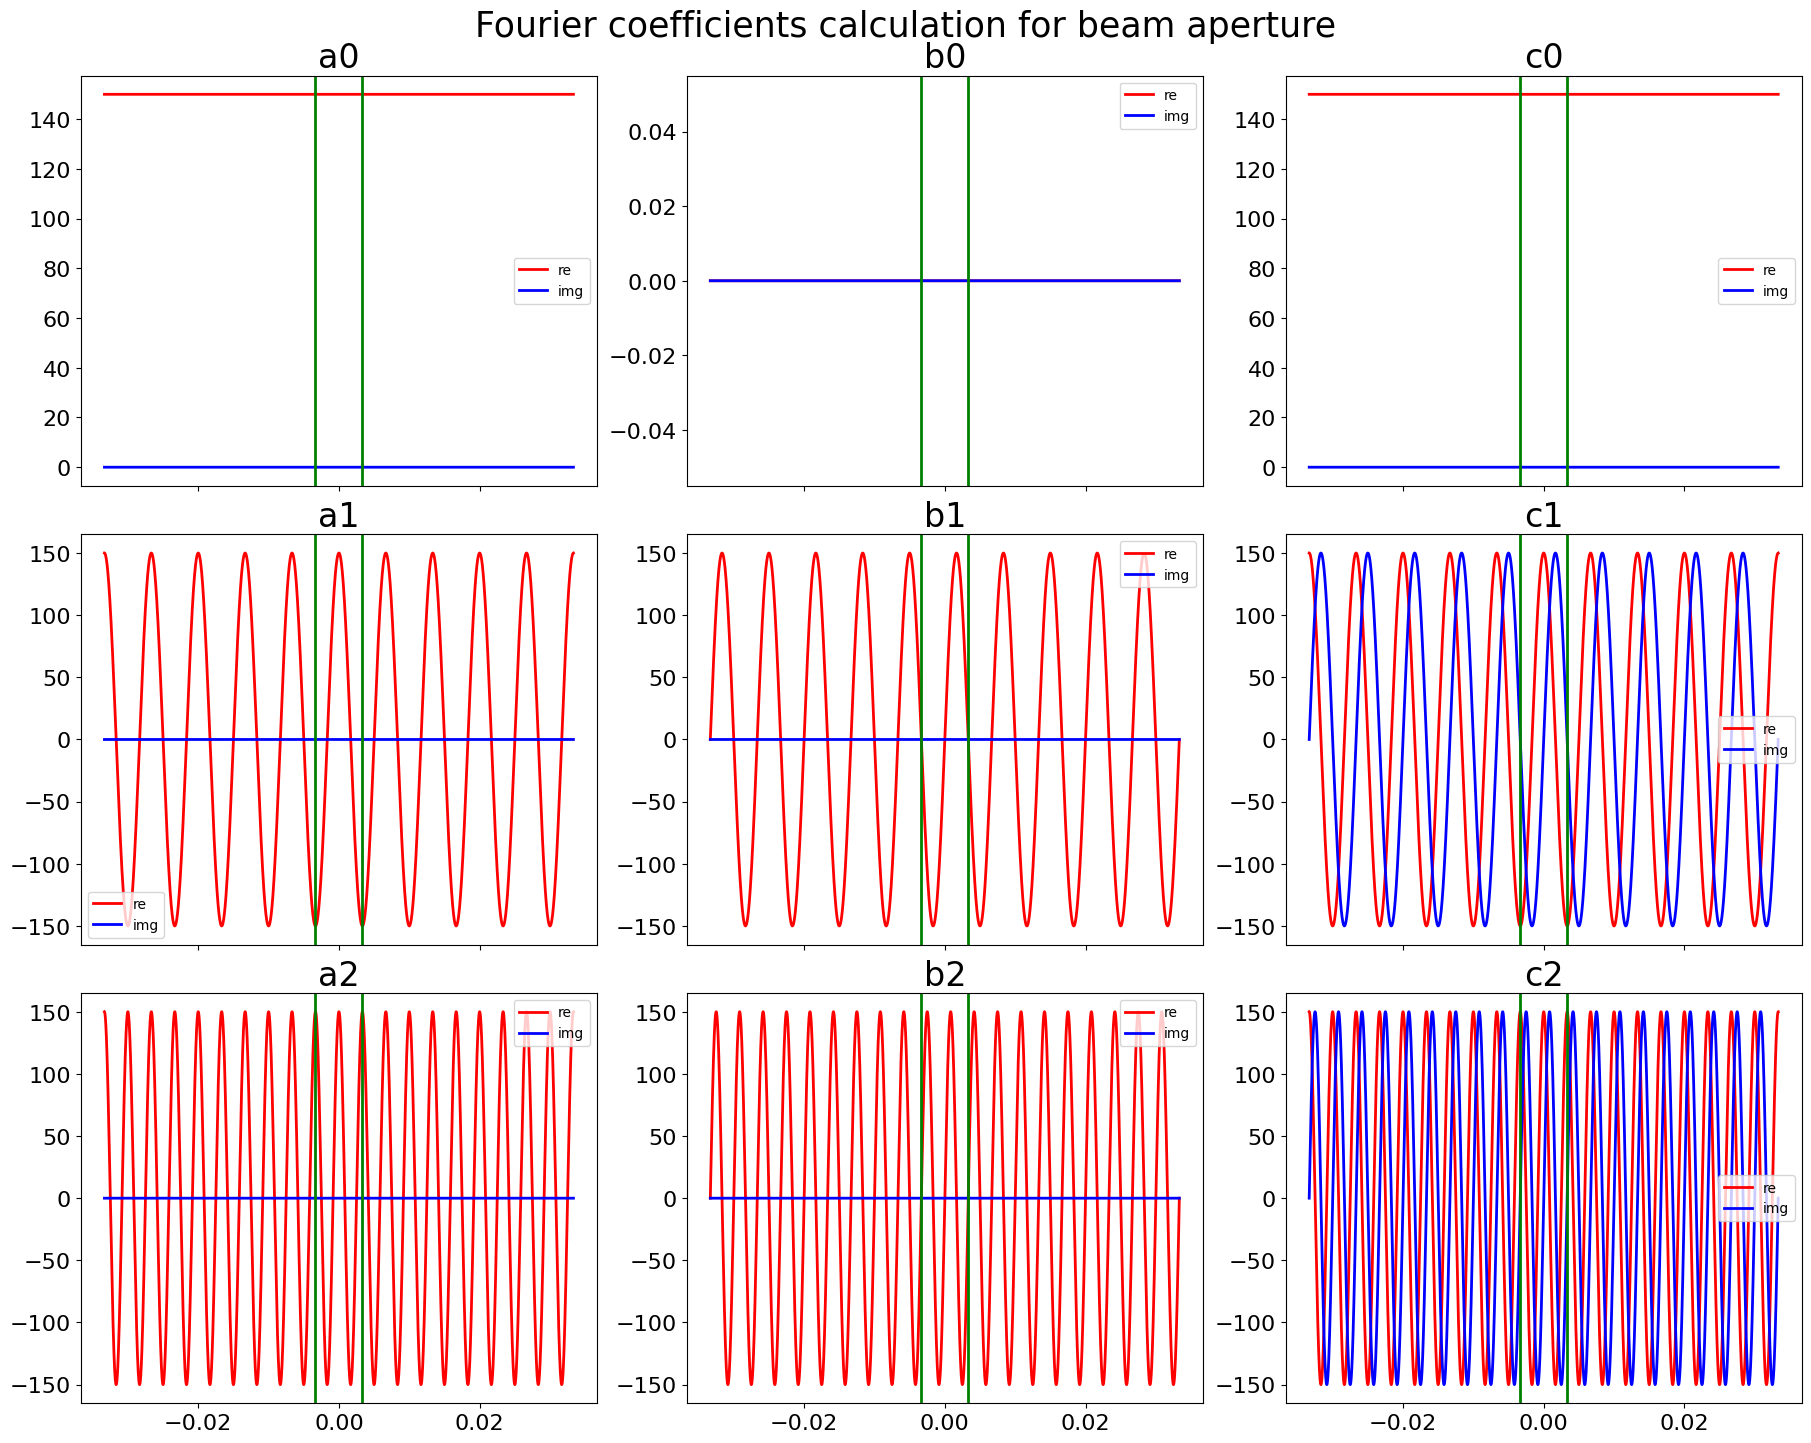

In [57]:
fig,axs = plt.subplots(3,3,figsize=(18,14),sharex=True,layout="constrained")
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.flatten()

y_a0 = integrand_an_v0(xrange, 0)
y_b0 = integrand_bn_v0(xrange, 0)
y_c0 = integrand_cn_v0(xrange, 0)

y_a1 = integrand_an_v0(xrange, 1)
y_b1 = integrand_bn_v0(xrange, 1)
y_c1 = integrand_cn_v0(xrange, 1)

y_a2 = integrand_an_v0(xrange, 2)
y_b2 = integrand_bn_v0(xrange, 2)
y_c2 = integrand_cn_v0(xrange, 2)

ax1.plot(xrange,y_a0.real,'r-',label="re")
ax1.plot(xrange,y_a0.imag,'b-',label="img")
ax1.set_title("a0")
ax1.axvline(-a/2,color="g")
ax1.axvline(a/2,color="g")
ax1.legend()

ax2.plot(xrange,y_b0.real,'r-',label="re")
ax2.plot(xrange,y_b0.imag,'b-',label="img")
ax2.set_title("b0")
ax2.axvline(-a/2,color="g")
ax2.axvline(a/2,color="g")
ax2.legend()

ax3.plot(xrange,y_c0.real,'r-',label="re")
ax3.plot(xrange,y_c0.imag,'b-',label="img")
ax3.set_title("c0")
ax3.axvline(-a/2,color="g")
ax3.axvline(a/2,color="g")
ax3.legend()

ax4.plot(xrange,y_a1.real,'r-',label="re")
ax4.plot(xrange,y_a1.imag,'b-',label="img")
ax4.set_title("a1")
ax4.axvline(-a/2,color="g")
ax4.axvline(a/2,color="g")
ax4.legend()

ax5.plot(xrange,y_b1.real,'r-',label="re")
ax5.plot(xrange,y_b1.imag,'b-',label="img")
ax5.set_title("b1")
ax5.axvline(-a/2,color="g")
ax5.axvline(a/2,color="g")
ax5.legend()

ax6.plot(xrange,y_c1.real,'r-',label="re")
ax6.plot(xrange,y_c1.imag,'b-',label="img")
ax6.set_title("c1")
ax6.axvline(-a/2,color="g")
ax6.axvline(a/2,color="g")
ax6.legend()


ax7.plot(xrange,y_a2.real,'r-',label="re")
ax7.plot(xrange,y_a2.imag,'b-',label="img")
ax7.set_title("a2")
ax7.axvline(-a/2,color="g")
ax7.axvline(a/2,color="g")
ax7.legend()


ax8.plot(xrange,y_b2.real,'r-',label="re")
ax8.plot(xrange,y_b2.imag,'b-',label="img")
ax8.set_title("b2")
ax8.axvline(-a/2,color="g")
ax8.axvline(a/2,color="g")
ax8.legend()


ax9.plot(xrange,y_c2.real,'r-',label="re")
ax9.plot(xrange,y_c2.imag,'b-',label="img")
ax9.set_title("c2")
ax9.axvline(-a/2,color="g")
ax9.axvline(a/2,color="g")
ax9.legend()

fig.suptitle(f"Fourier coefficients calculation for beam aperture",y=1.02,fontsize=25)

In [55]:
if FLAG_FULL_INTERF:
    def integrand_an_v2(x, n):
        return (np.cos(2*np.pi*n*x/a)*twosourcesinterf1D_1_A(x,C,DPSI))/a
    def integrand_bn_v2(x, n):
        return (np.sin(2*np.pi*n*x/a)*twosourcesinterf1D_1_A(x,C,DPSI))/a
    def integrand_cn_v2(x, n):
        return (np.exp(2j*np.pi*n*x/a)*twosourcesinterf1D_1_A(x,C,DPSI))/a
    
elif FLAG_PARTIAL_INTERF:
    def integrand_an_v2(x, n):
        return (np.cos(2*np.pi*n*x/a)*twosourcesinterf1D_2_A(x,C,DPSI))/a
    def integrand_bn_v2(x, n):
        return (np.sin(2*np.pi*n*x/a)*twosourcesinterf1D_2_A(x,C,DPSI))/a
    def integrand_cn_v2(x, n):
        return (np.exp(2j*np.pi*n*x/a)*twosourcesinterf1D_2_A(x,C,DPSI))/a
    
else:
    def integrand_an_v2(x, n):
        return (np.cos(2*np.pi*n*x/a)*twosourcesinterf1D_3_A(x,C,DPSI))/a
    def integrand_bn_v2(x, n):
        return (np.sin(2*np.pi*n*x/a)*twosourcesinterf1D_3_A(x,C,DPSI))/a
    def integrand_cn_v2(x, n):
        return (np.exp(2j*np.pi*n*x/a)*twosourcesinterf1D_3_A(x,C,DPSI))/a
    

#def integrand_an_v2(x, n):
#    return (np.cos(2*np.pi*n*x/a)*twosourcesinterf1D_1_A(x,C,DPSI))/a
#def integrand_bn_v2(x, n):
#    return (np.sin(2*np.pi*n*x/a)*twosourcesinterf1D_1_A(x,C,DPSI))/a
#def integrand_cn_v2(x, n):
#    return (np.exp(2j*np.pi*n*x/a)*twosourcesinterf1D_1_A(x,C,DPSI))/a

Text(0.5, 1.02, 'full true interference pattern : Fourier series coefficients calculation')

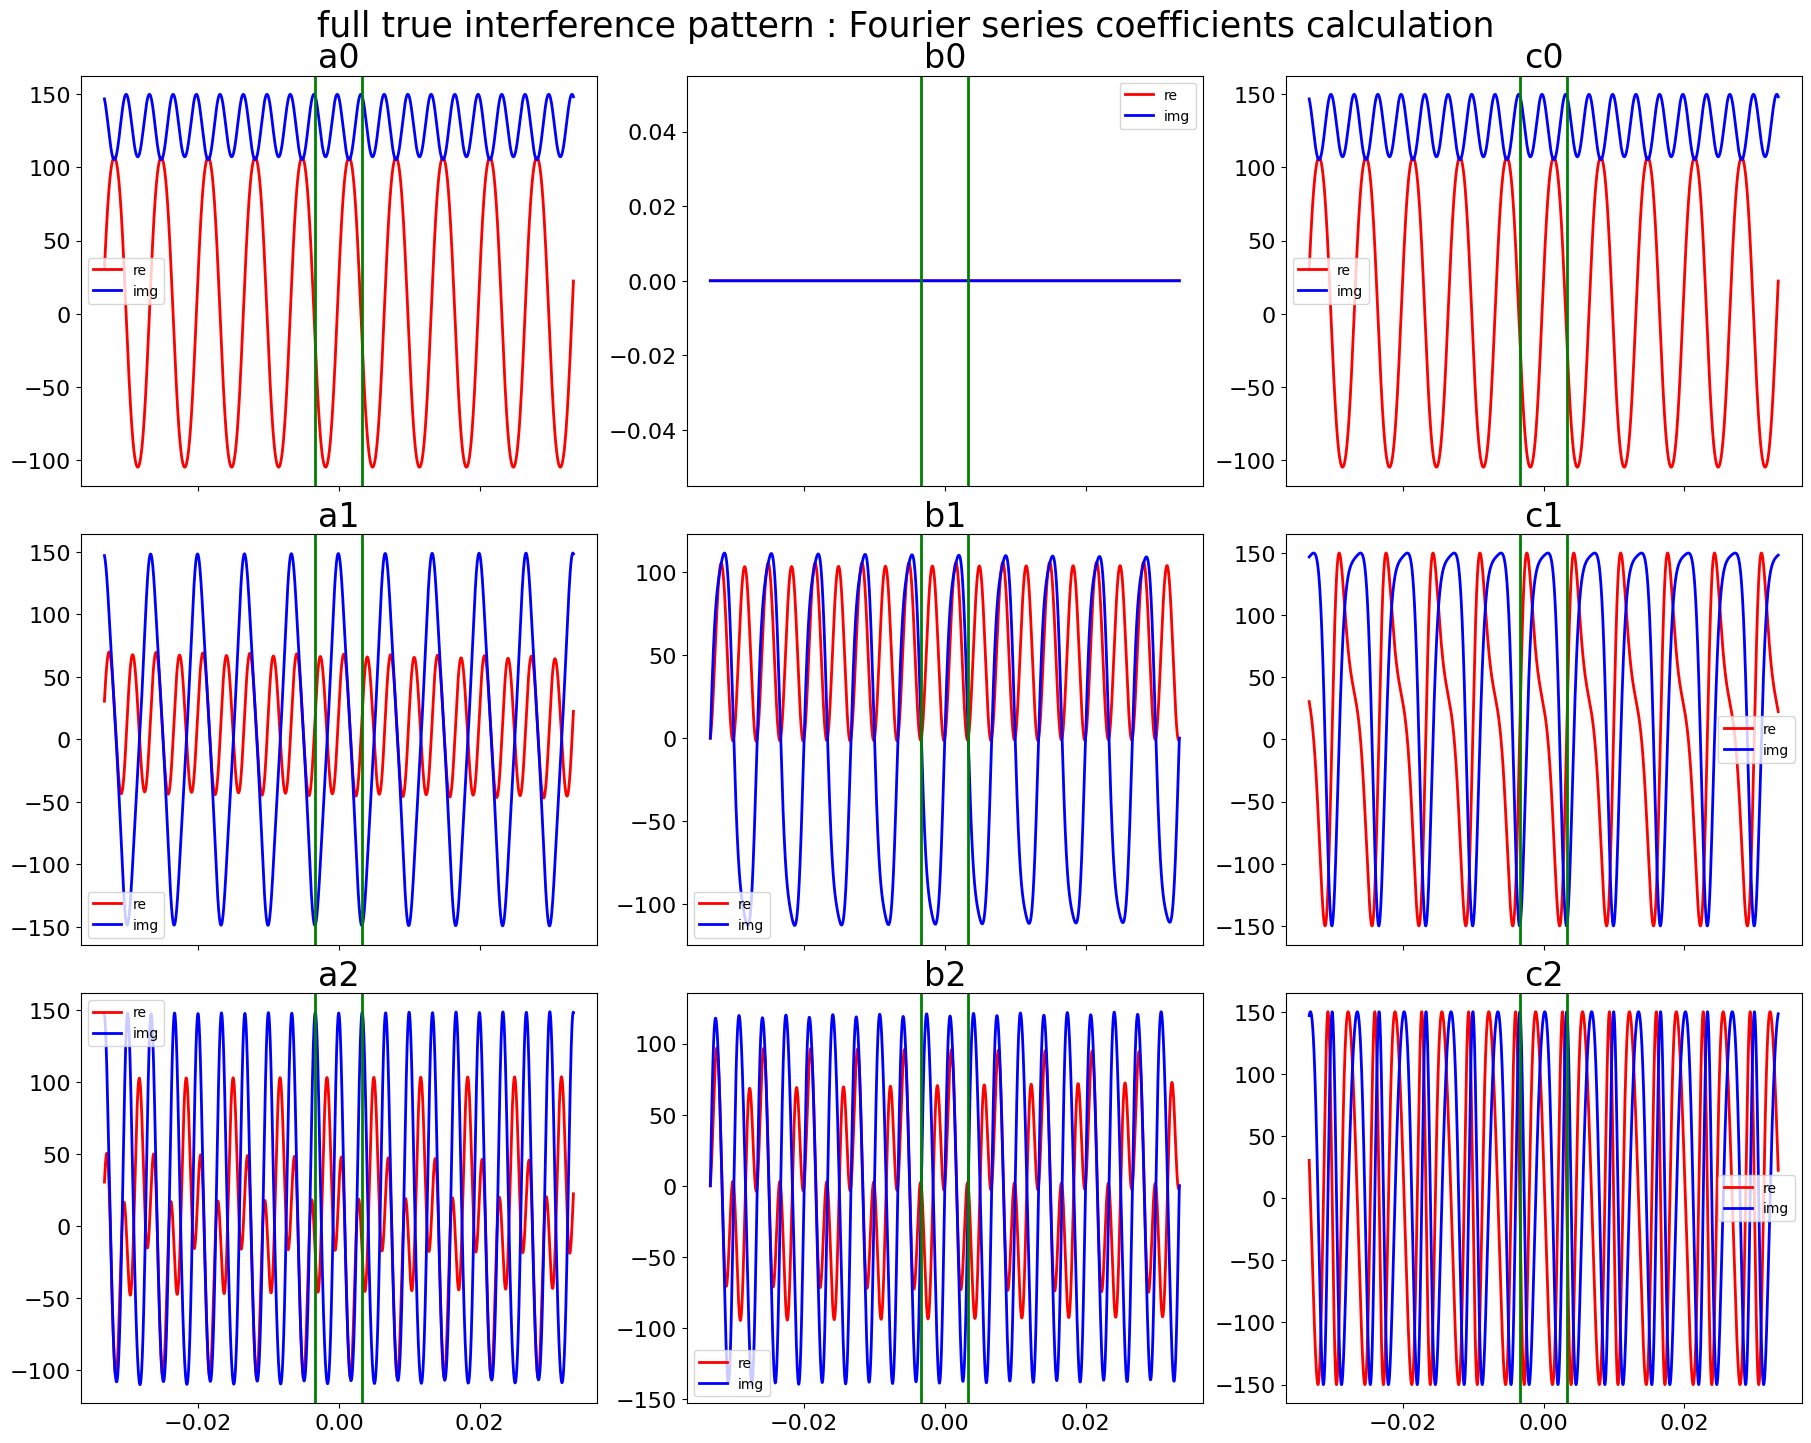

In [56]:
fig,axs = plt.subplots(3,3,figsize=(18,14),sharex=True,layout="constrained")
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.flatten()

y_a0 = integrand_an_v2(xrange, 0)
y_b0 = integrand_bn_v2(xrange, 0)
y_c0 = integrand_cn_v2(xrange, 0)

y_a1 = integrand_an_v2(xrange, 1)
y_b1 = integrand_bn_v2(xrange, 1)
y_c1 = integrand_cn_v2(xrange, 1)

y_a2 = integrand_an_v2(xrange, 2)
y_b2 = integrand_bn_v2(xrange, 2)
y_c2 = integrand_cn_v2(xrange, 2)

ax1.plot(xrange,y_a0.real,'r-',label="re")
ax1.plot(xrange,y_a0.imag,'b-',label="img")
ax1.set_title("a0")
ax1.axvline(-a/2,color="g")
ax1.axvline(a/2,color="g")
ax1.legend()

ax2.plot(xrange,y_b0.real,'r-',label="re")
ax2.plot(xrange,y_b0.imag,'b-',label="img")
ax2.set_title("b0")
ax2.axvline(-a/2,color="g")
ax2.axvline(a/2,color="g")
ax2.legend()

ax3.plot(xrange,y_c0.real,'r-',label="re")
ax3.plot(xrange,y_c0.imag,'b-',label="img")
ax3.set_title("c0")
ax3.axvline(-a/2,color="g")
ax3.axvline(a/2,color="g")
ax3.legend()

ax4.plot(xrange,y_a1.real,'r-',label="re")
ax4.plot(xrange,y_a1.imag,'b-',label="img")
ax4.set_title("a1")
ax4.axvline(-a/2,color="g")
ax4.axvline(a/2,color="g")
ax4.legend()

ax5.plot(xrange,y_b1.real,'r-',label="re")
ax5.plot(xrange,y_b1.imag,'b-',label="img")
ax5.set_title("b1")
ax5.axvline(-a/2,color="g")
ax5.axvline(a/2,color="g")
ax5.legend()

ax6.plot(xrange,y_c1.real,'r-',label="re")
ax6.plot(xrange,y_c1.imag,'b-',label="img")
ax6.set_title("c1")
ax6.axvline(-a/2,color="g")
ax6.axvline(a/2,color="g")
ax6.legend()


ax7.plot(xrange,y_a2.real,'r-',label="re")
ax7.plot(xrange,y_a2.imag,'b-',label="img")
ax7.set_title("a2")
ax7.axvline(-a/2,color="g")
ax7.axvline(a/2,color="g")
ax7.legend()


ax8.plot(xrange,y_b2.real,'r-',label="re")
ax8.plot(xrange,y_b2.imag,'b-',label="img")
ax8.set_title("b2")
ax8.axvline(-a/2,color="g")
ax8.axvline(a/2,color="g")
ax8.legend()


ax9.plot(xrange,y_c2.real,'r-',label="re")
ax9.plot(xrange,y_c2.imag,'b-',label="img")
ax9.set_title("c2")
ax9.axvline(-a/2,color="g")
ax9.axvline(a/2,color="g")
ax9.legend()
fig.suptitle(f"{tag} : Fourier series coefficients calculation",y=1.02,fontsize=25)